In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

## Load excel from `calc_DO_impaired_ts` script

In [31]:
fname = "SOG_NB_baseline_wc_impaired_m0p25_TS_byRegion.xlsx"
pathname = pathlib.Path(
    "/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/"\
    "SOG_NB/DOXG/wqm_baseline/spreadsheets/")
run_tag = 'Current Conditions'

In [13]:
tsdf=pandas.read_excel(pathname/fname)
readme=pandas.read_excel(
    pathname/fname, 
    sheet_name='README',
    index_col=0
)
tsdf=tsdf.drop('Unnamed: 0',axis=1)

In [25]:
impairment=float(readme.loc['Impairment threshold [mg/l]'].item().split(' ')[0])
impairment

-0.25

In [7]:
with open('../etc/SSM_config.yaml', 'r') as file:
        ssm = yaml.safe_load(file)
color = [ssm['region']['colors'][region] for region in [*tsdf]]

In [39]:
tsdf.head(1)

,Hood,Main,SFJAdmiralty,SOG_Bellinghham,SouthSound,Whidbey,ALL_REGIONS
0,0.0,0.0,0,0.0,0.000158,0.0,0.000004


In [28]:
time = np.arange(tsdf.shape[0])+ssm['run_information']['spin_up_days']

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


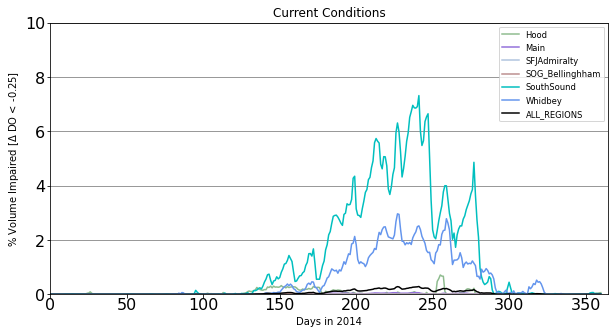

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                       gridspec_kw={
                           'width_ratios': [1],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.2})
tsdf.plot(ax=ax,
    kind="line",
    color=color,
    legend=True
)
#ax.set_xticklabel(time)
ax.set_ylabel(f'% Volume Impaired [$\Delta$ DO < {impairment}]')
ax.set_xlabel('Days in 2014')
ax.set_title(run_tag)
ax.set_ylim(0,10)
ax.set_xlim(0,365)
ax.grid(axis='y', color='grey')

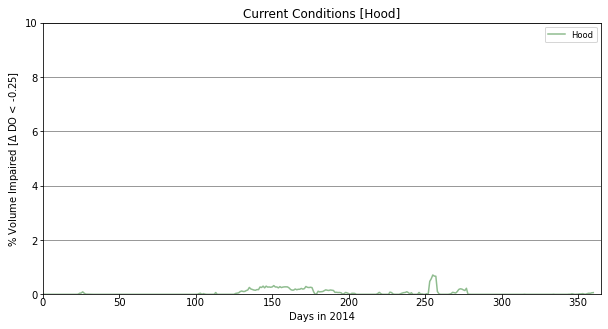

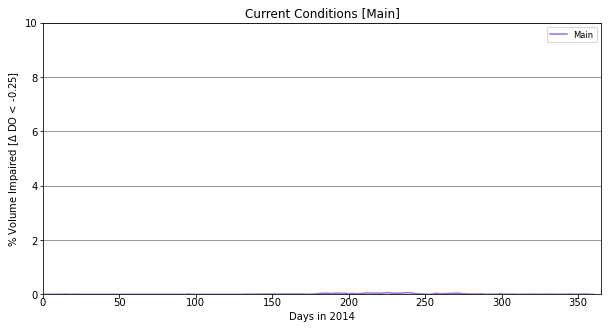

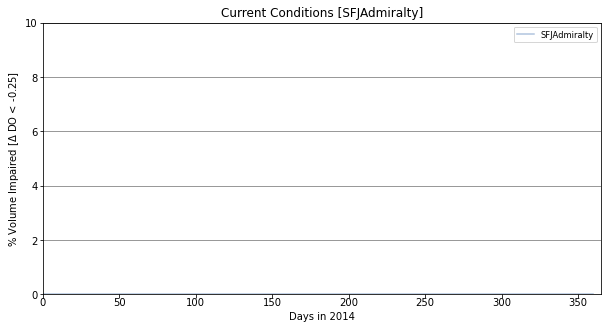

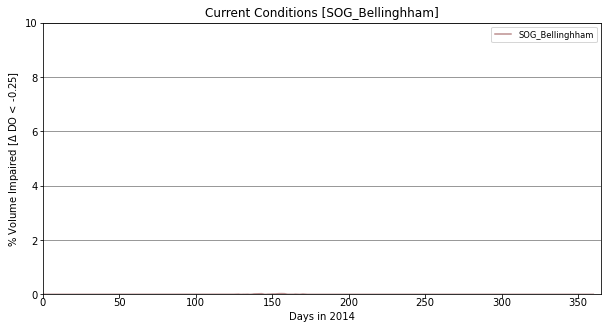

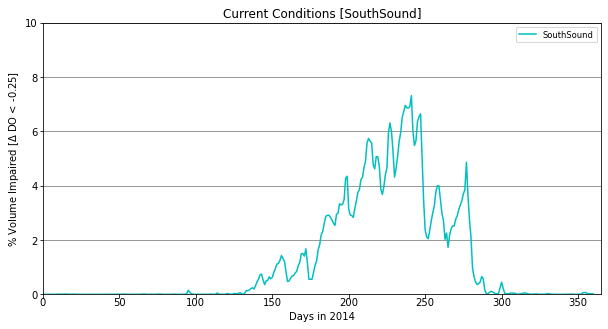

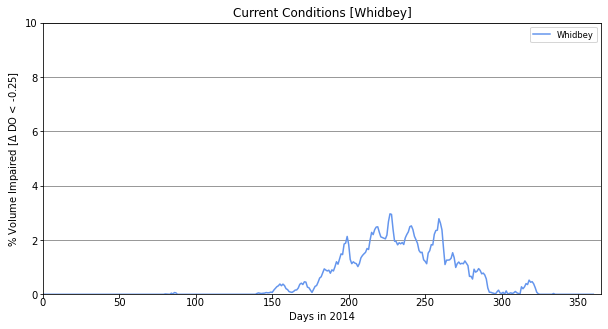

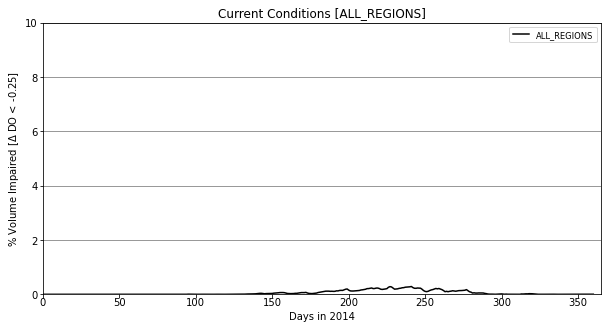

In [42]:
for region in [*tsdf]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                           gridspec_kw={
                               'width_ratios': [1],
                               'height_ratios': [1],
                           'wspace': 0.4,
                           'hspace': 0.2})
    tsdf[region].plot(ax=ax,
        kind="line",
        color=ssm['region']['colors'][region],
        legend=True
    )
    #ax.set_xticklabel(time)
    ax.set_ylabel(f'% Volume Impaired [$\Delta$ DO < {impairment}]')
    ax.set_xlabel('Days in 2014')
    ax.set_title(f'{run_tag} [{region}]')
    ax.set_ylim(0,10)
    ax.set_xlim(0,365)
    ax.grid(axis='y', color='grey')

#### NOTE:
- Need to shift days by 5
- Fix legend labels
- Add axis label
- Modify/correct colors

## The code below was development code

In [2]:
case = "SOG_NB"
model_var="DOXG"
impairment = -0.2

In [3]:
# Start time counter
start = time.time()

# Load yaml file containing path definitions.  This file is created by
# https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/etc/SSM_config.ipynb
# but can also be modified here (with the caveat the modifications will be 
# over-written when the SSM_config.ipynb is run
# https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/etc/SSM_config.yaml
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']

In [4]:
# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

nnodes=4144
nlevels=10

# Calculate volume for volume days
volume = np.asarray(gdf.volume)
depth_fraction = np.array(ssm['siglev_diff'])/100
volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))
    

In [5]:
volume2D.transpose().shape

(10, 4144)

In [6]:
volume3D = np.repeat(volume2D.transpose()[np.newaxis, :, :], 361, axis=0)
volume3D.shape

(361, 10, 4144)

In [7]:
# Initialize dictionaries
MinDO_full={} # Min, daily DO over all nodes
MinDO={} # Min, daily DO over all nodes in shapefile
DO_diff_lt_0p2={} # Boolean where DO<threshold
DO_diff_lt_0p2_days={} # Number of days where DOBelowThresh = True
DaysImpaired={} # Sum of days across regions
VolumeDaysImpaired={} # Percent of volume within region where DO<threshold
PercentVolumeDaysImpaired={}

# ********  START NEW  ***********
DO_diff_lt_0p2_wc = {}


In [8]:
# Get path for model output 
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/case/model_var

# Get list of run sub-directories in processed netcdf directory
dir_list = os.listdir(processed_netcdf_dir)

In [9]:
dir_list[0:2]

['wqm_reference', '1c_all_sog_riv_off']

In [10]:
# Load minimum DO results
for run_dir in dir_list[0:2]:
    try: 
        run_file=processed_netcdf_dir/run_dir/f'daily_min_{model_var}.nc'
        with xarray.open_dataset(run_file) as ds:
            print([*ds])
            MinDO_full[run_dir]=ds[f'{model_var}_daily_min']
            # Sub-sample nodes (from 16012 nodes to 7494)
            MinDO[run_dir]=MinDO_full[run_dir][:,:,gdf['node_id']-1]
            print(MinDO[run_dir].shape)
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')
    if run_dir == dir_list[0]:
        # Get number of days and nodes
        [ndays,nlevels,nnodes]=MinDO[run_dir].shape

['DOXG_daily_min']
(361, 10, 4144)
['DOXG_daily_min']
(361, 10, 4144)


In [11]:
# Calculate volume for volume days
volume = np.asarray(gdf.volume)
depth_fraction = np.array(ssm['siglev_diff'])/100
volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))

In [12]:
# Define reference run
reference = ssm['run_information']['reference']
print(reference)
dir_list.remove(reference)

wqm_reference


In [13]:
dir_list[0:1]

['1c_all_sog_riv_off']

In [14]:
# Loop through all non-reference runs and calculate impairment
for run_type in dir_list[0:1]:
    print(f'Calculating difference for {run_type}')
    # Create array of Dissolved Oxygen threshold values 
    DO_diff = MinDO[run_type] - MinDO[reference]
    # Boolean where DO_diff < -0.2 (or impairment value)
    DO_diff_lt_0p2[run_type] = DO_diff<=impairment #361x4144 (nodes x time) or 361x10x4144
    # Number of days where DO < threshold = True
    # ************ START NEW ****************
    # Take max over depth level to flag node as impaired if impaired anywhere in 
    # water column
    DO_diff_lt_0p2_wc[run_type]=DO_diff_lt_0p2[run_type].max(
        axis=1, initial=0)
    # **** START NEW ******
    output_directory = processed_netcdf_dir/run_type/'movies'/'impairment'
    # create output directory, if is doesn't already exist 
    # see https://docs.python.org/3/library/os.html#os.makedirs
    if os.path.exists(output_directory)==False:
        print(f'creating: {output_directory}')
        os.umask(0) #clears permissions
        os.makedirs(processed_netcdf_dir/run_type/'movies', mode=0o777,exist_ok=True)
        os.makedirs(processed_netcdf_dir/run_type/'movies'/'impairment',
                    mode=0o777,exist_ok=True)
    # **** END NEW ********

Calculating difference for 1c_all_sog_riv_off


In [15]:
[ti,ni]=DO_diff_lt_0p2_wc[run_type].shape
print(ti,ni)

361 4144


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


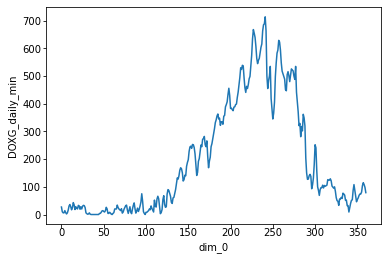

In [16]:
DO_diff_lt_0p2_wc[run_type].sum(axis=1).plot()

In [17]:
DO_diff_lt_0p2_wc[run_type][1,:].shape

(4144,)

In [18]:
regions

['Hood', 'Main', 'SFJAdmiralty', 'SOG_Bellinghham', 'SouthSound', 'Whidbey']

In [19]:
# loop through time and add impairment to gdf and plot red where impaired
region = "SOG_Bellinghham"


In [ ]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

for day in range(ti):
    output_file = output_directory/f'{case}_{run_type}_{region}_impairment3D_{day}.png'
    
    gdf['Impaired']=DO_diff_lt_0p2_wc[run_type][day,:]
    gdf_impaired = gdf.loc[
        ((gdf['Regions']==region) &
        (gdf['included_i']==1) & 
        (gdf['Impaired']==True))
    ]
    gdf_good = gdf.loc[
        ((gdf['Regions']==region) &
        (gdf['included_i']==1) & 
        (gdf['Impaired']==False))
    ]
    
    fig, axs = plt.subplots(1,1, figsize = (8,8))
    #~~~ Location map ~~~
    gdf_impaired.plot(ax=axs,color='red',legend=True,
                     label='Time series location')
    gdf_good.plot(ax=axs,color='blue',legend=True,
                     label='Time series location')
    cx.add_basemap(axs, crs=gdf.crs,alpha=1)   
    axs.set_title(f'{region} impaired nodes for day {day} of 2014')
    axs.set_xticklabels('')
    axs.set_yticklabels('')
    
#     # Zoom into Bbay so we can actualy see overlap
#     if region == "SOG_Bellinghham":
#         axs.set_ylim(5.37e6,5.42e6)
#         axs.set_xlim(5e5,5.4e5)
#         axs.text(5.01e5,5.386e6,"Orcas Is.")
#         axs.text(5.3e5,5.405e6,"Nooksack R.")
#         axs.text(5.18e5,5.415e6,"Pt. Whitehorn")
    
     
    plt.savefig(output_file, bbox_inches='tight', format='png')
   
    #*************  Entire domain ****************
    gdf_impaired = gdf.loc[
        ((gdf['included_i']==1) & 
        (gdf['Impaired']==True))
    ]
    gdf_good = gdf.loc[
        ((gdf['included_i']==1) & 
        (gdf['Impaired']==False))
    ]
    fig, axs = plt.subplots(1,1, figsize = (8,8))
    #~~~ Location map ~~~
    gdf_impaired.plot(ax=axs,color='red',legend=True,
                     label='Time series location')
    gdf_good.plot(ax=axs,color='blue',legend=True,
                     label='Time series location')
    cx.add_basemap(axs, crs=gdf.crs,alpha=1)   
    axs.set_title(f'Impaired nodes for day {day} of 2014')
#     axs.set_xticklabels('')
#     axs.set_yticklabels('')
    
#     # Zoom into Bbay so we can actualy see overlap
#     if region == "SOG_Bellinghham":
#         axs.set_ylim(5.37e6,5.42e6)
#         axs.set_xlim(5e5,5.4e5)
#         axs.text(5.01e5,5.386e6,"Orcas Is.")
#         axs.text(5.3e5,5.405e6,"Nooksack R.")
#         axs.text(5.18e5,5.415e6,"Pt. Whitehorn")
    
    output_file = output_directory/f'{case}_{run_type}_all_impairment3D_{day}.png'
    plt.savefig(output_file, bbox_inches='tight', format='png')

/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/.conda/envs/klone_jupyter/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are at